In [1]:
#####################################################
# Author: Prof. Marc Jofre
# Dept. Network Engineering
# Universitat Politècnica de Catalunya - Technical University of Catalonia
#
# Modified: 2024
# Created: 2024
#
# Script Quantum LAN application Server layer
#####################################################
import sys, os
# !pip install numpy
import numpy as np
#!pip install --upgrade pip
#!pip install --upgrade pillow
#!pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
#from google.colab import files
#print(plt.style.available)
mpl.style.use('default')
import time

pathScriptBelowAgentScript='./CppScripts/'
sys.path.append(pathScriptBelowAgentScript)
pathScriptBelowAgentScript='./JupyterPythonScripts/'
sys.path.append(pathScriptBelowAgentScript)

import QpresentationLayerAgent

#####################################################
# Parameters
## Network
IPhostServerOpNet = "127.0.0.1"#10.0.0.3" # IP address of the server host (this host) in the operational network
IPhostServerConNet = "192.168.9.1" # IP address of the server host (this host) in the control/configuration network
IPnodeServerConNet = "192.168.9.2" # IP address of the server node (connected to the server host) in the control/configuration network
IPhostClientOpNet = "10.0.0.1" # IP address of the host client (connected to the server host) in the operational network
IPnodeClientConNet = "192.168.8.2" # IP address of the client node (connecte to the client host) in the control/configuration network

ParamsServerListChar = [IPnodeServerConNet,IPhostClientOpNet,IPhostServerOpNet,IPhostServerConNet,"server"]

##############################################################
# Functions
def ListCharArrayParser(ListCharArrayAux):
    # Actually concatenating a python list of strings to a single string
    ParsedCharArrayAux=",".join(ListCharArrayAux)+","
    return ParsedCharArrayAux

# The parameters passed and received from agents are structured
ParamsAscendingCharArray = "none"
ParamsDescendingCharArray = ListCharArrayParser(ParamsServerListChar)

### RUN UP TO HERE (INCLUDED) TO INITIALIZE CONNECTIONS AND THREAD QtransportLayerAgentH thread #####
# At this point, in this order, the node in the server has been initialized, the node in the client, the server host (up to this equivalent point) and then the client host (up to here)
# Create instance of Agent below
QPLAagent = QpresentationLayerAgent.QPLA(ParamsDescendingCharArray,ParamsAscendingCharArray)
### Initiate thread process in QtransportLayerAgentH
QPLAagent.InitAgentProcess() # Initialize the thread in QtransportLayerAgentH

In [ ]:
#####################
# Some tests to send information to the different elements and see them output at the respective console
# The required fields of a message are (separated by commas): IPdestination,IPorigin,Type,Command,Payload
messagePayloadAux="Host server sends information to attached node"
messageCommandAux="print"
messageTypeAux="Info"
messageIPorg=IPhostServerOpNet
messageIPdest=IPnodeServerConNet
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host server sends information to client host"
messageCommandAux="print"
messageTypeAux="Info"
messageIPorg=IPhostServerOpNet
messageIPdest=IPhostClientOpNet
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host server sends information to host client node"
messageCommandAux="print"
messageTypeAux="Control"
messageIPorg=IPhostServerOpNet
messageIPdest=IPhostClientOpNet # Notice that it is send to the host (which it will forward it to the node)
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

In [2]:
#### Some test to request QuBits from the other host #################
QPLAagent.RequestQubitsHost(IPhostClientOpNet,IPhostServerOpNet,IPnodeServerConNet,IPhostServerOpNet,128) # Request that host's node sends qubits to this host's node
NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
QPLAagent.RetrieveNumStoredQubitsNode(NumStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
print('NumStoredQubitsNode[0]: '+str(NumStoredQubitsNode[0]))

NumStoredQubitsNode[0]: 1027


In [6]:
###### Hard resilience test #######
import random
import time
NumTestMax = 1000
ListNumStoredQubitsNode=[]
for iIterTest in range(0,NumTestMax,1):
    RandomTestNum=random.randint(0, 1)
    if (RandomTestNum==0):
        # Sending messages
        messagePayloadAux="Host server sends information to attached node"
        messageCommandAux="print"
        messageTypeAux="Info"
        messageIPorg=IPhostServerOpNet
        messageIPdest=IPnodeServerConNet
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host server sends information to client host"
        messageCommandAux="print"
        messageTypeAux="Info"
        messageIPorg=IPhostServerOpNet
        messageIPdest=IPhostClientOpNet
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host server sends information to host client node"
        messageCommandAux="print"
        messageTypeAux="Control"
        messageIPorg=IPhostServerOpNet
        messageIPdest=IPhostClientOpNet # Notice that it is send to the host (which it will forward it to the node)
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
    else:
        # Sending request
        QPLAagent.RequestQubitsHost(IPhostClientOpNet,IPhostServerOpNet,IPnodeServerConNet,IPhostServerOpNet,128) # Request that host's node sends qubits to this host's node
        NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
        QPLAagent.RetrieveNumStoredQubitsNode(NumStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
        ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
    time.sleep(20.0)
    time.sleep(int(20.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))

ListNumStoredQubitsNode: [1053, 1040, 983, 1022, 1006, 1049, 1046, 1002, 1045, 948, 956, 1021, 957, 996, 993, 1063, 1096, 1041, 1049, 54, 1073, 1038, 1075, 1009, 1026, 1082, 1033, 1033, 1015, 920, 1102, 1038, 1011, 1018, 974, 985, 1039, 1071, 1032, 1022, 1022, 1057, 965, 965, 1061, 1010, 1042, 1059]


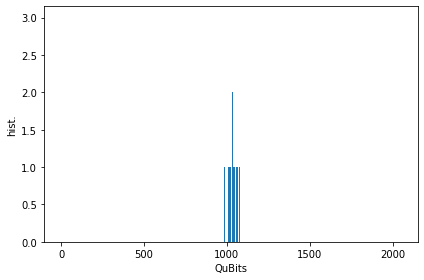

In [8]:
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,2049,1))
plt.xlabel('QuBits')
plt.ylabel('hist.')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()